# Librerias

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import glob

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.utils.np_utils import to_categorical
from keras.layers.core import Dropout, Activation

import gc
import random
import os

import cv2
from cv2 import imread, resize

import itertools

In [20]:
# Paths Dataset & Metadata

metadata_path = r'.\data\HAM10000_metadata.csv'
lista1_path = r'.\data\HAM10000_images_part_1'
lista2_path = r'.\data\HAM10000_images_part_2'

In [21]:
# Metadata

df_metadata = pd.read_csv(metadata_path)
df_metadata.fillna({'age': np.mean(df_metadata['age'])}, inplace=True) # Completamos las edades vacias con el valor promedio.
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           10015 non-null  float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [22]:
# Columna dx: Abreviaturas y Nombres Completos de los tipos de lesiones

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ', 'Basal cell carcinoma','Actinic keratoses',
                'Vascular lesions', 'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Agregar el tipo de lesion completo y el id
df_metadata['lesion_type']=df_metadata['dx'].map(lesion_type_dict)
df_metadata['lesion_ID'] = df_metadata['dx'].map(lesion_ID_dict)
df_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,lesion_ID
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


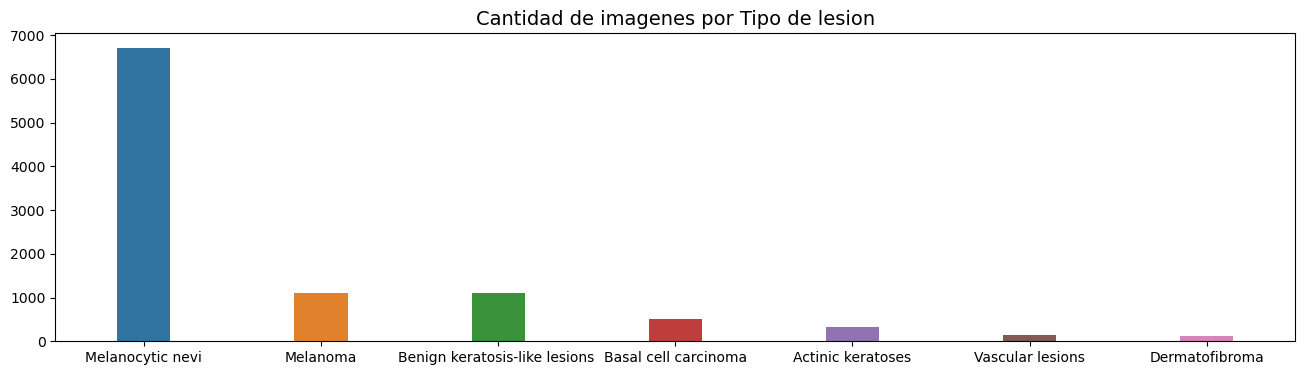

,Tipo de lesion,cantidad
0,Melanocytic nevi,6705
1,Melanoma,1113
2,Benign keratosis-like lesions,1099
3,Basal cell carcinoma,514
4,Actinic keratoses,327
5,Vascular lesions,142
6,Dermatofibroma,115


In [23]:
# Verificar si nuestro dataset esta balanceado por tipo de lesion

value_counts = df_metadata['lesion_type'].value_counts()
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Tipo de lesion', 'cantidad']

# Graficar
plt.figure(figsize=(16, 4))
sns.barplot(x='Tipo de lesion', y='cantidad', data=value_counts_df , width=0.3)
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de imagenes por Tipo de lesion', size = 14)
plt.show()

value_counts_df

In [24]:
# Agregar columna con el path de las imagenes de cada caso
image_paths = []

for part in (lista1_path, lista2_path):
    image_paths = image_paths + glob.glob(part+"/*.jpg")

image_ids_n_paths = {os.path.splitext(os.path.basename(path))[0]:path for path in image_paths}

df_metadata['path']= df_metadata['image_id'].map(image_ids_n_paths)
labels = df_metadata['dx'].to_frame()
df_metadata = df_metadata.drop('dx', axis=1)
labels = pd.get_dummies(labels)

df_metadata.head(2)

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,lesion_ID,path
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0025030.jpg


In [26]:
def generarImagenesRotadas(img2):
    imga = cv2.rotate(img2,cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2,cv2.ROTATE_180)
    imgd = cv2.flip(img2,0)
    imge = cv2.flip(img2,1)
    return imga,imgb,imgc,imgd,imge

In [27]:
X = []
y = []

for index, row in df_metadata.iterrows():

    file_to_read = row['path']
    img = imread(file_to_read)
    img2 = resize(img,(100,100))
    
    X.append(img2)
    y.append(row['lesion_ID'])
    
    if row['lesion_ID'] != 0:
        new_img = generarImagenesRotadas(img2)
        for i in range(5):
            X.append(new_img[i])
            y.append(row['lesion_ID'])

print(len(X))
print(len(y))

26565
26565


# TRANSFORMACIÓN

In [28]:
X = np.array(X)
y = np.array(y)

# Usamos la función to_categorical para convertir nuestras etiquetas enteras en codigo one-hot, donde cada vector binario 
# corresponde a una etiqueta de la clase
y_train = to_categorical(y, num_classes = 7)

# Dividimos la data en 70% entrenamiento y 30% testeo
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size = 0.30, random_state = 50, stratify = y)       
print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (18595, 100, 100, 3)
Test dataset shape (7970, 100, 100, 3)


In [29]:
# Definimos pesos para nuestras clases, como solución para la data no balanceada
def est_class_weights(dis_id: np.array) -> dict:
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))
    return class_weights

y_id = np.array(df_metadata['lesion_ID'])

new_class_weights = est_class_weights(y_id)

print(new_class_weights)

{0: 0.57, 1: 0.57, 2: 0.58, 3: 1.23, 4: 1.93, 5: 4.45, 6: 5.5}


# CREACIÓN DE LA RED NEURONAL CONVOLUCIONAL (CNN)

In [30]:
modeloCNN = Sequential([
    # 1ra Capa Convolucional
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(100,100,3)),
    # 96 filtros
    # Activación relu: Solucionar valores negativos que tomaran el valor de 0 y los positivos su mismo valor
    # Matriz de 11x11
    # Solo a esta capa se le coloca el input_shape por que recibe la data como neurona de entrada
    BatchNormalization(), # Mejora el entrenamiento del modelo
    MaxPool2D(pool_size=(3,3), strides=(2,2)), # Capa de reduccion o Pooling

    # 2da Capa Convolucional
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
  
    # 3ra Capa Convolucional
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
     
    # 4ta Capa Convolucional
    Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
       
    # 5ta Capa Convolucional
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    Flatten(), # Vectorizacion de Salida: Pasar nuestros datos 2x2 a una dimension (lista)
    
    # 6ta Capa
    Dense(4096, activation='relu'), # Capa Oculta
    Dropout(0.5),
    
    # 7ma Capa
    Dense(4096, activation='relu'), # Capa Oculta
    Dropout(0.5),
    
    # 8va Capa
    Dense(7, activation='softmax') # Capa de Salida
    #Activacion sofmax: Se usa cuando nuestras probabilidades de salida no comparten una suma igual al 100% (Normalizar)
])

## Entrenamiento

In [31]:
# Metodo para monitorear el entrenamiento y evitar el sobreajuste
callback_monitoreo = EarlyStopping(patience = 100, monitor = 'val_accuracy')

# Metodo Callback para obtener el mejor modelo
callback_modeloTOP = ModelCheckpoint(filepath = 'ModeloCNN.h5',
                                  save_weights_only = False,
                                  monitor = 'val_accuracy', 
                                  mode = 'auto', 
                                  save_best_only = True, 
                                  verbose = 1)

optimizador_Adam = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)

modeloCNN.compile(optimizer = optimizador_Adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(zoom_range = 0.2, 
                             horizontal_flip = True, 
                             shear_range = 0.2)
datagen.fit(X_train)


history = modeloCNN.fit(datagen.flow(X_train,y_train),
                    epochs = 100,
                    batch_size = 32,
                    shuffle = True,
                    callbacks = [callback_monitoreo, callback_modeloTOP],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights)

C:\Users\1\.conda\envs\EntornoProyectoCapstone\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
582/582 [==============================] - ETA: 0s - loss: 1.7758 - accuracy: 0.3922
Epoch 1: val_accuracy improved from -inf to 0.05747, saving model to ModeloCNN.h5
582/582 [==============================] - 117s 197ms/step - loss: 1.7758 - accuracy: 0.3922 - val_loss: 5.8043 - val_accuracy: 0.0575
Epoch 2/100
582/582 [==============================] - ETA: 0s - loss: 1.3273 - accuracy: 0.4807
Epoch 2: val_accuracy improved from 0.05747 to 0.24304, saving model to ModeloCNN.h5
582/582 [==============================] - 102s 176ms/step - loss: 1.3273 - accuracy: 0.4807 - val_loss: 3.3264 - val_accuracy: 0.2430
Epoch 3/100
582/582 [==============================] - ETA: 0s - loss: 1.2003 - accuracy: 0.5140
Epoch 3: val_accuracy improved from 0.24304 to 0.40025, saving model to ModeloCNN.h5
582/582 [==============================] - 100s 172ms/step - loss: 1.2003 - accuracy: 0.5140 - val_loss: 1.5757 - val_accuracy: 0.4003
Epoch 4/100
582/582 [==============================]

Epoch 29/100
582/582 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.7711
Epoch 29: val_accuracy improved from 0.68118 to 0.69636, saving model to ModeloCNN.h5
582/582 [==============================] - 100s 172ms/step - loss: 0.4307 - accuracy: 0.7711 - val_loss: 0.8126 - val_accuracy: 0.6964
Epoch 30/100
582/582 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.7760
Epoch 30: val_accuracy improved from 0.69636 to 0.72396, saving model to ModeloCNN.h5
582/582 [==============================] - 99s 171ms/step - loss: 0.4075 - accuracy: 0.7760 - val_loss: 0.7009 - val_accuracy: 0.7240
Epoch 31/100
582/582 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.7906
Epoch 31: val_accuracy did not improve from 0.72396
582/582 [==============================] - 103s 177ms/step - loss: 0.3706 - accuracy: 0.7906 - val_loss: 0.9874 - val_accuracy: 0.6242
Epoch 32/100
582/582 [==============================] - ETA: 0s - loss: 0.3633

Epoch 57/100
582/582 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.8782
Epoch 57: val_accuracy did not improve from 0.84605
582/582 [==============================] - 98s 169ms/step - loss: 0.2207 - accuracy: 0.8782 - val_loss: 0.5105 - val_accuracy: 0.8201
Epoch 58/100
582/582 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.8847
Epoch 58: val_accuracy did not improve from 0.84605
582/582 [==============================] - 99s 170ms/step - loss: 0.1970 - accuracy: 0.8847 - val_loss: 0.6681 - val_accuracy: 0.7821
Epoch 59/100
582/582 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.8580
Epoch 59: val_accuracy did not improve from 0.84605
582/582 [==============================] - 100s 172ms/step - loss: 0.2624 - accuracy: 0.8580 - val_loss: 1.3417 - val_accuracy: 0.6277
Epoch 60/100
582/582 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.8765
Epoch 60: val_accuracy did not improve from 0.846

582/582 [==============================] - 103s 176ms/step - loss: 0.1327 - accuracy: 0.9258 - val_loss: 0.4116 - val_accuracy: 0.8612
Epoch 86/100
582/582 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9268
Epoch 86: val_accuracy did not improve from 0.89285
582/582 [==============================] - 98s 168ms/step - loss: 0.1293 - accuracy: 0.9268 - val_loss: 0.3905 - val_accuracy: 0.8763
Epoch 87/100
582/582 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9197
Epoch 87: val_accuracy did not improve from 0.89285
582/582 [==============================] - 101s 173ms/step - loss: 0.1513 - accuracy: 0.9197 - val_loss: 0.3506 - val_accuracy: 0.8807
Epoch 88/100
582/582 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9314
Epoch 88: val_accuracy did not improve from 0.89285
582/582 [==============================] - 103s 177ms/step - loss: 0.1242 - accuracy: 0.9314 - val_loss: 0.5618 - val_accuracy: 0.8143
Epoch 89/10

## Resultado

In [32]:
# Evaluamos el Modelo Entrenado usando la data de testeo
scores = modeloCNN.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

250/250 [==============================] - 8s 34ms/step - loss: 0.3840 - accuracy: 0.8668
Accuracy: 86.68%


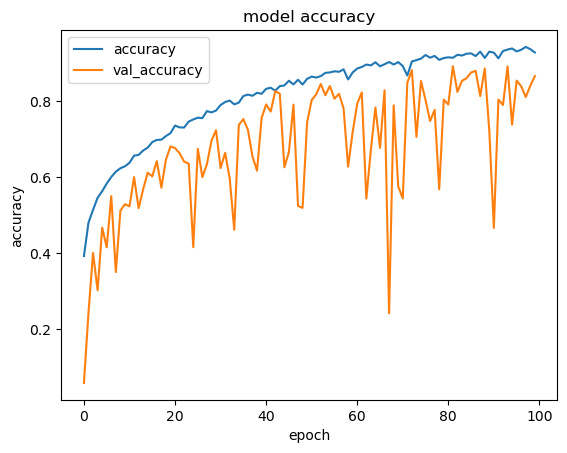

In [33]:
# Ver historico para el ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

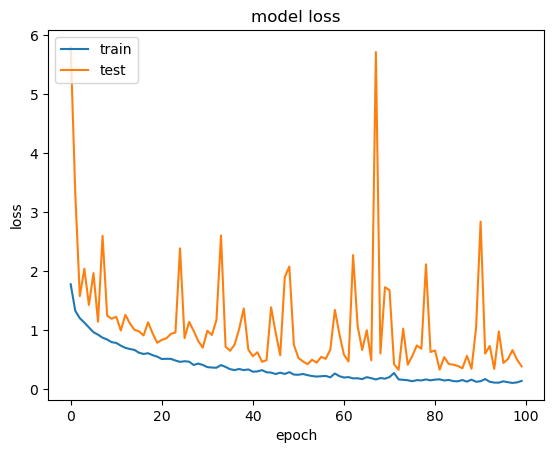

In [34]:
# Ver historico para el LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Best Model

In [ ]:
best_model = load_model('./ModeloCNN.h5')

y_pred_prob = np.around(best_model.predict(X_test), 3)
y_pred = np.argmax(y_pred_prob, axis = 1)

y_test2 = np.argmax(y_test, axis = 1)

In [37]:
scores = best_model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

250/250 [==============================] - 10s 37ms/step - loss: 0.3284 - accuracy: 0.8928
Accuracy: 89.28%


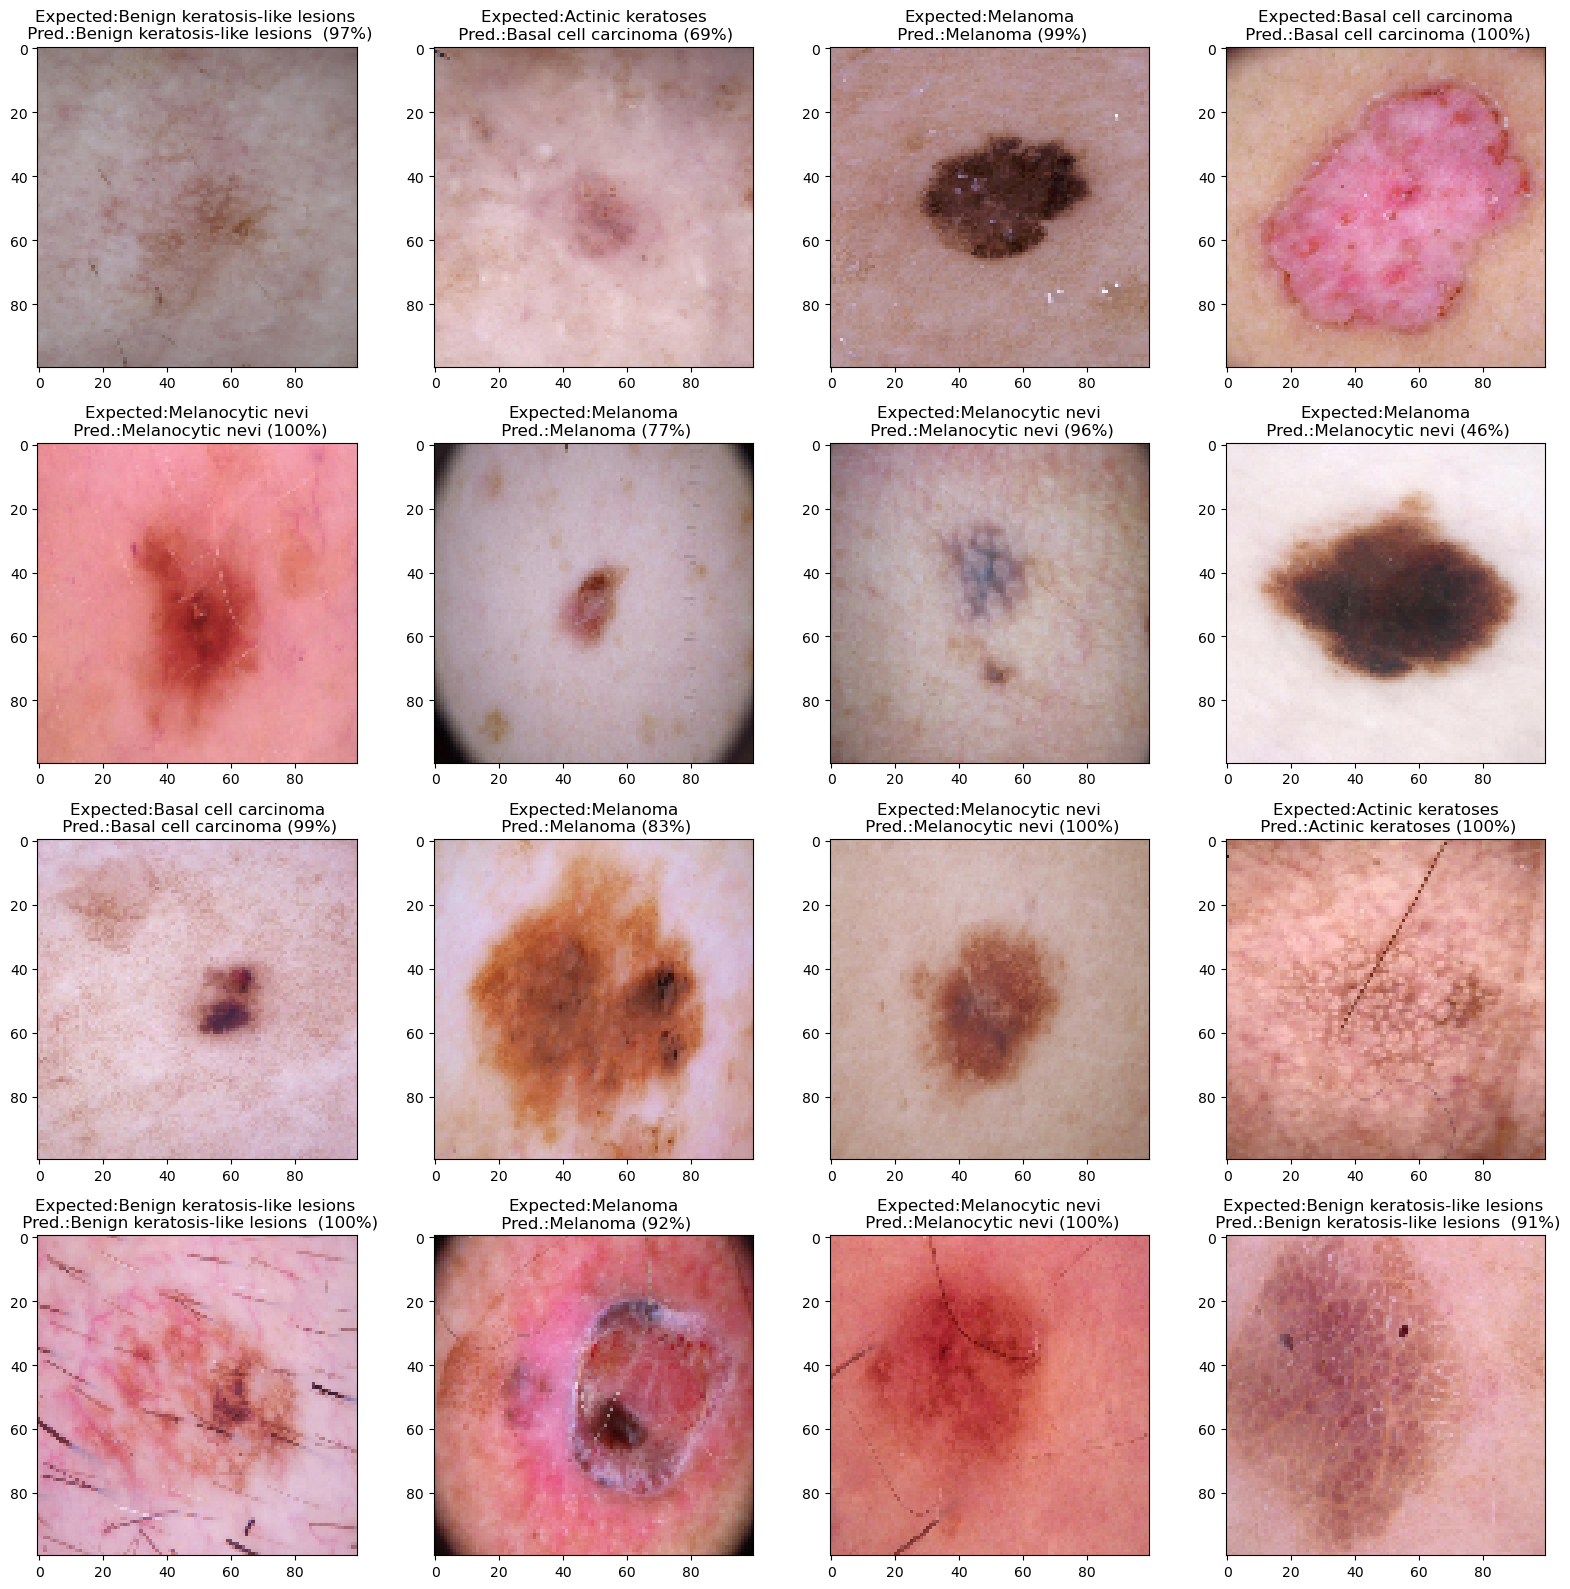

In [38]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
#plt.savefig('final_figure.png',dpi=300)
plt.show()

In [47]:
#Accuracy por cada tipo
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.82
accuracy for Melanoma = 0.89
accuracy for Benign keratosis-like lesions  = 0.9
accuracy for Basal cell carcinoma = 0.97
accuracy for Actinic keratoses = 0.92
accuracy for Vascular lesions = 1.0
accuracy for Dermatofibroma = 0.98


In [48]:
y_test = np.argmax(y_test, axis=1) #Esta funcion nos permite regresar los valores a como estaban antes

y_pred = modeloCNN.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

250/250 [==============================] - 8s 34ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84      2012
           1       0.91      0.77      0.83      2003
           2       0.91      0.86      0.88      1978
           3       0.92      0.95      0.93       925
           4       0.73      0.95      0.83       589
           5       0.98      0.98      0.98       256
           6       0.92      0.94      0.93       207

    accuracy                           0.87      7970
   macro avg       0.88      0.91      0.89      7970
weighted avg       0.87      0.87      0.87      7970



# Validando CASOS MELANOMA

In [42]:
df_metadata.head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,lesion_ID,path
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,histo,75.0,male,ear,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_2\ISIC_0031633.jpg


In [43]:
df_metadata['lesion_type'].unique()

array(['Benign keratosis-like lesions ', 'Melanocytic nevi',
       'Dermatofibroma', 'Melanoma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [44]:
df_metadata[df_metadata['lesion_type']=='Melanoma'].head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,lesion_ID,path
1211,HAM_0000871,ISIC_0025964,histo,40.0,female,chest,Melanoma,1,.\data\HAM10000_images_part_1\ISIC_0025964.jpg
1212,HAM_0000871,ISIC_0030623,histo,40.0,female,chest,Melanoma,1,.\data\HAM10000_images_part_2\ISIC_0030623.jpg
1213,HAM_0000040,ISIC_0027190,histo,80.0,male,upper extremity,Melanoma,1,.\data\HAM10000_images_part_1\ISIC_0027190.jpg
1214,HAM_0005678,ISIC_0031023,histo,60.0,male,chest,Melanoma,1,.\data\HAM10000_images_part_2\ISIC_0031023.jpg
1215,HAM_0005678,ISIC_0028086,histo,60.0,male,chest,Melanoma,1,.\data\HAM10000_images_part_1\ISIC_0028086.jpg


In [77]:
df_metadata[df_metadata['lesion_type']!='Melanoma'].head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,lesion_ID,path
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,histo,80.0,male,scalp,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,histo,75.0,male,ear,Benign keratosis-like lesions,2,.\data\HAM10000_images_part_2\ISIC_0031633.jpg


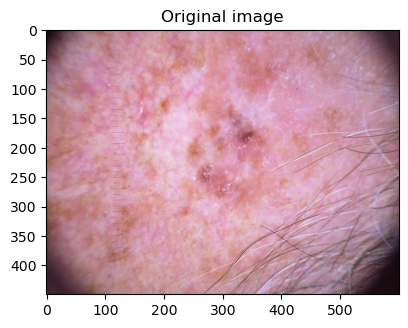

In [87]:
img_prueba = r'.\data\HAM10000_images_part_1\ISIC_0025661.jpg'

var_img = []
img = imread(img_prueba)
img2 = resize(img,(100,100))
var_img.append(img2)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.title('Original image')
plt.show()

In [88]:
var_img = np.array(var_img)

best_model_u = load_model('./ModeloCNN.h5')
u_pred_prob = np.around(best_model_u.predict(var_img), 3)
u_pred = np.argmax(u_pred_prob, axis = 1)

1/1 [==============================] - 0s 262ms/step


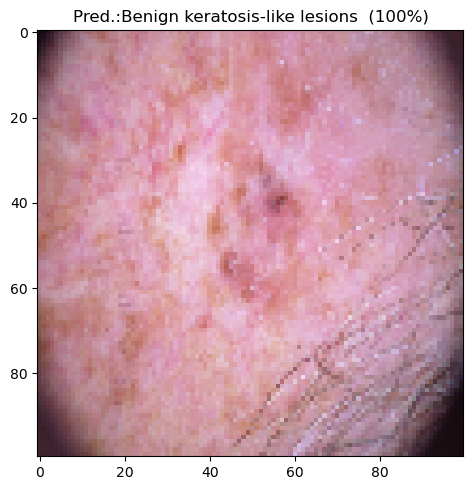

Evaluacion completa....
Imagen Generada.....
Tipo de Lesión: Benign keratosis-like lesions  --- Probabilidad: (100%)


In [92]:
plt.figure(figsize=(5,5))
index = 0
plt.imshow(var_img[index,:,:,::-1])
label_pred = lesion_names[u_pred[index]]
label_pred_prob = round(np.max(u_pred_prob[index])*100)
plt.title('Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('Imagen_Validada.png', dpi=300)
plt.show()
print("Evaluacion completa....")
print("Imagen Generada.....")
print("Tipo de Lesión: "+ str(label_pred) + ' --- Probabilidad: ('+str(label_pred_prob)+'%)')